Calculateur d'itinéraire vélo à apprentissage supervisé
=============================

(Toute ma gratitude à qui trouve un nom plus vendeur)

Bienvenue sur la page de test ! Ceci est un notebook jupyter. Il y a des blocs de simple texte et des blocs de code. Pour tester le programme, faire shift+entrée sur les blocs de code les uns après les autres en suivant les instructions. Le * qui appraît à côté de « Entrée » signifie que L'ordinateur réfléchit. Attendez qu'un numéro s'affiche pour passer à la suite.
 Vous pouvez modifier les arguments des fonctions. En fait vous pouvez faire ce que vous voulez : ceci est une copie qui sera immédiatement effacée.

Principe du programme
------------------------

Le fichier csv chemins.csv contient une liste d'itinéraires rentrés par des cyclistes. La petite IA programmée dans le module «apprentissage» va en déduire un coefficient de cyclabilité pour chaque tronçon de route. Et le calculateur d'itinéraires prendra cette cyclabilité en compte.

Pour commencer on charge les bibliothèques. Patience, c'est un peu lourd, notamment à cause de chargement en mémoire de la carte openstreetmap.

In [1]:
#Pour permettre l'affichage interactif des figures (zoom notamment)
import matplotlib
matplotlib.use('nbagg')

In [2]:
#bibs Python

import networkx as nx # graphe
import osmnx as ox
#import requests
#import matplotlib.cm as cm
#import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)

#Modules de ce projet
from module_graphe import graphe #ma classe de graphe
from init_graphe import g # le graphe de Pau agglo par défaut
import apprentissage
import dijkstra
import chemins # classe chemin et lecture du csv

Chargement du xml données/voies_et_nœuds.osm
fini

Graphe en mémoire !
Calcul de la version sans multiarêtes
Chargement du cache nœud_of_rue.
Chargement du graphe fini.



_Chargement du fichier csv_

In [3]:
tous_les_chemins = chemins.chemins_of_csv(g)

['oui', '30', '20 chemin Guilhem; avenue Sambre et Meuse;cours Bosquet; place de la République']
['oui', '30', 'rue des réparatrices; avenue San Carlos;avenue des acacias;avenue de Montebello;avenue Bié Moulié;rue Gutenberg']
['oui', '30', 'avenue du Loup;chemin des écoliers;rue Mozart;chemin Guilhem']
['oui', '30', 'Rond-Point Éric Tabarly; Chemin Labriart; Rue Cassiopée; Rue Blanqui; Rue Paul Bert; Rue Marx Dormoy; CSTJF']
['oui', '20', "rue d'étigny; place gramont; rue tran; place de la libération; rue gassiot; rue carnot; rue cazaubon norbert; boulevard d'alsace-lorraine; cours lyautey; avenue de saragosse; avenue de buros; 84 avenue de buros"]
['oui', '20', "véloroute V81 (64320 mazères-lezons) ; véloroute V81 (64320 bizanos)  ; 13 rue de verdun (64320 bizanos) ; avenue albert 1er (64320 bizanos) ; 69 rue pasteur (64320 bizanos) ; 58 rue pasteur (64320 bizanos) ; 35 rue pasteur (64320 bizanos) ; 11 rue pasteur (64320 bizanos) ; 13 avenue de barèges (64000 PAU) ; avenue léon say (6

Pour les tests, la fonction suivante permet de rajouter des chemins à la mains :

In [4]:
def ajoute_chemin(étapes, AR=True, pourcentage_détour=30):
    """ Entrées : - étapes (str list) liste des adresses des étapes.
                  - AR (bool) indique si le retour est valable aussi
                  - pourcentage_détour (int) pourcentage de détour accepté par le cycliste qui propose cet iténéraire."""
    tous_les_chemins.append(chemins.Chemin.of_étapes(étapes, pourcentage_détour, AR, g))

Voici un exemple d'utilisation. Concernant l'argument pourcentage_détour, voici le point de référence : 100 signifie que le cycliste accepte de faire un trajet deux fois plus long pour remplacer un trajet qui serait en totalité comme la rue Faisans par un trajet qui serait en totalité comme la piste cyclable du Fébus.

In [5]:
ajoute_chemin( ["1 rue Louis Barthou", "rue Lamothe", "rue Jean Monnet", "rue Galos", "place de la république"], True, 20)

La fonction suivante indique pour tous les chemins présents dans le csv le chemin le plus court (rouge) et le chemin indiqué dans le fichier (en bleu). En outre elle lance l'apprentissage.

In [6]:
def affiche_avant_après(chemins, g, nb_lectures):
    
    chemins_avant = [ dijkstra.chemin(g, c.départ(), c.arrivée(), 0) for c in chemins ]
    #g.réinitialise_cyclabilité()
    apprentissage.n_lectures(nb_lectures, g, chemins, bavard=1)
    
    chemins_après = [ dijkstra.chemin(g, c.départ(), c.arrivée(), c.p_détour) for c in chemins ]
    
    g.affiche_chemins( chemins_avant+chemins_après, {"route_colors":['r']*len(chemins_avant)+['b']*len(chemins_après)} )

Maintenant que la fonction a été créée, il faut la lancer !
Le paramètre nb_lectures est le nombre de fois qu'on va présenter les chemins à l'IA.

In [ ]:
affiche_avant_après(tous_les_chemins, g, 10)

Début de l'apprentissage. C'est parti pour 10 lectures.
10
9
8


Pour zoomer, c'est l'icone en rectangle sous l'image.
Cliquer sur le bouton en faut à gauche de l'image pour arrêter le mode interactif.

La fonction finale : prend deux adresses et affiche l'itinéraire. L'argument p_détour est la proportion de détour acceptée. 0=pas de détour.

In [9]:
def itinéraire(départ, arrivée, p_détour, g):
    """ Fonction finale. Affiche l'itinéraire, en utilisant le graphe déjà entrainé."""
    id_d = g.nœud_centre_rue(départ)
    id_a = g.nœud_centre_rue(arrivée)
    c = g.chemin(id_d, id_a, p_détour)
    g.affiche_chemin(c)

Utilisation de la fonction finale. Remplacez les adresses par ce que vous voulez (à Pau pour l'instant...). Gardez en tête que les adresses sont retrouvées depuis openstreetmap, qui n'a pas très à l'ausi avec les fautes de frappe.

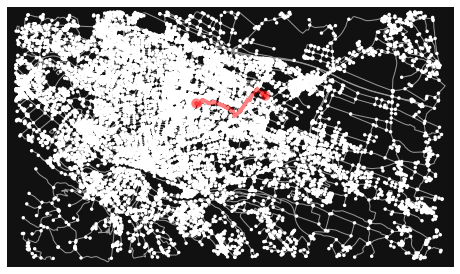

In [10]:
itinéraire("rue Roger Salengro", "rue Jean Moulin",.5, g)


Si on veut bien voir l'apport de l'IA, la fonction suivante afiche d'abord le chemin le plus court classique, puis lance l'apprentissage, et affiche le nouveau chemin en bleu.

In [13]:
def test(départ, arrivée, p_détour, n = 0):
    """ Entrée : départ et arrivée, des adresses (type str)
                 n, nb de lectures de tous les chemins. Si l'apprentissage a déjà été fait auparavant, laiser 0.
        Effet : affiche en rouge le plus court chemin, et en bleu le chemin qui tient compte de l'apprentissage."""

    id_d = g.nœud_centre_rue(départ)
    id_a = g.nœud_centre_rue(arrivée)

    chemin_avant = g.chemin(id_d, id_a, 0) # En mettant p_détour à 0, on sélectionne le plus court chemin


    apprentissage.n_lectures(n, g, tous_les_chemins, bavard=1)

    chemin_après = g.chemin(id_d, id_a, p_détour)

    g.affiche_chemins([chemin_avant, chemin_après], {"route_colors":["r","b"]})

Début de l'apprentissage. C'est parti pour 0 lectures.


<IPython.core.display.Javascript object>


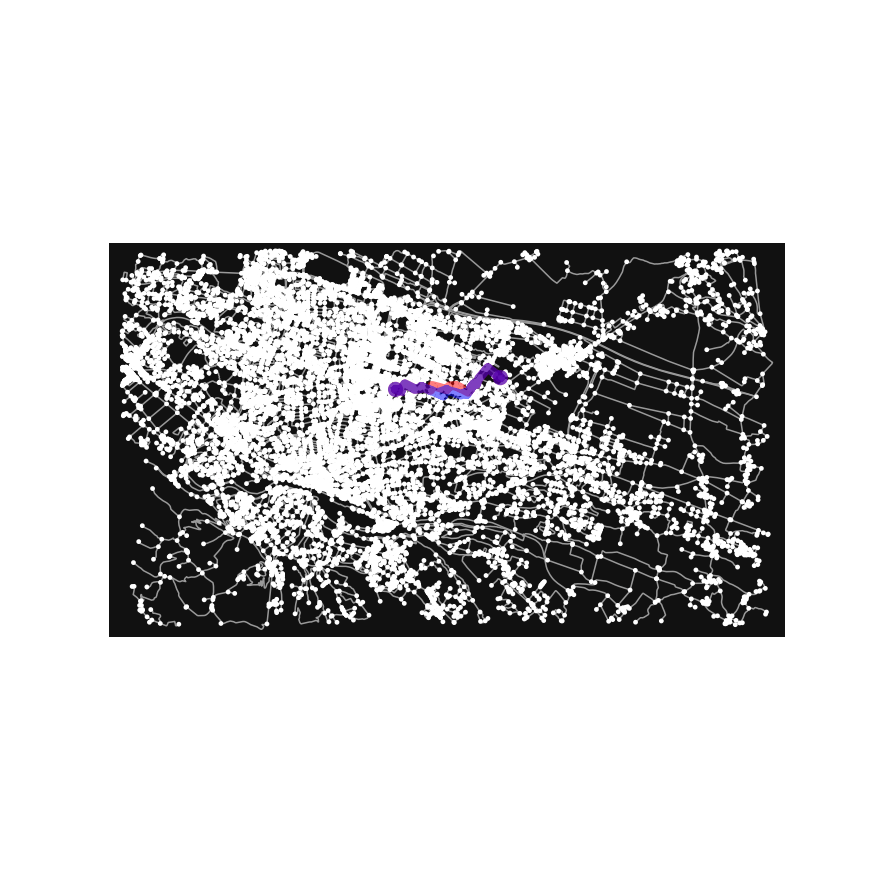

In [14]:
test("rue Roger Salengro", "rue Jean Moulin",.3)

Sur cet exemple on voit que l'IA a appris qu'il valait mieux passer par le chemin des écoles et la rue Mozart.